# Introduction to Forest-Guided Clustering (FGC): Simple Use Cases

📚 This tutorial provides a basic introduction to using the Forest-Guided Clustering (FGC) Python package for interpreting trained Random Forest models. You'll learn:

1. How to install the Forest-Guided Clustering package
2. How to apply it to your trained Random Forest model
3. How to interpret the resulting visualizations and insights

📦 **Installation:** To get started, you need to install the `fgclustering` package. Please follow the instructions on the [official installation guide](https://forest-guided-clustering.readthedocs.io/en/latest/_getting_started/installation.html).

🚧 **Note:** The Forest-Guided Clustering method uncovers structure in your data by identifying the most influential features in your model's decision-making process. However, if your Random Forest model performs poorly (e.g., classification accuracy ≤ 70%), the extracted feature importances may not reflect meaningful patterns in the data. Ensure that your model has reasonable predictive performance before interpreting its structure using FGC.

**Imports:**

In [1]:
## Import the Forest-Guided Clustering package
from fgclustering import (
    forest_guided_clustering, 
    forest_guided_feature_importance, 
    plot_forest_guided_feature_importance, 
    plot_forest_guided_decision_paths,
    DistanceRandomForestProximity,
    ClusteringKMedoids,
)

## Imports for datasets
from palmerpenguins import load_penguins
from sklearn.datasets import load_breast_cancer, fetch_california_housing

## Additional imports for use-cases
import pandas as pd

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV

/opt/anaconda3/envs/fgc/lib/python3.12/site-packages/palmerpenguins/penguins.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Use Case 1: Forest-Guided Clustering with a Random Forest Classifier (Binary Classification)

In this first use case, we apply Forest-Guided Clustering to a simple binary classification problem using a Random Forest classifier.

### 🎀 Data Pre-Processing and Model Training

We use the Breast Cancer dataset from `sklearn.datasets` (see the official description [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)). This dataset consists of 569 samples, including: 212 malignant tumors (class 0) and 357 benign tumors (class 1). Each tumor is characterized by 30 numerical features, which are computed from digitized images of breast masses.

In [2]:
data_breast_cancer = load_breast_cancer(as_frame=True)
data_breast_cancer = data_breast_cancer.frame
data_breast_cancer['target'] = data_breast_cancer['target'].map({0: 'malignant', 1: 'benign'})
data_breast_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


To begin, we train a Random Forest classifier on the full Breast Cancer dataset. Instead of performing an explicit train/test split, we rely on the out-of-bag (OOB) score, which provides an internal estimate of model accuracy using the bootstrap samples generated during training. This allows us to evaluate model performance without holding out a separate test set.

We perform a grid search with 5-fold cross-validation to optimize the following hyperparameters:

- `max_depth`: the maximum depth of each tree in the forest
- `max_features`: the number of features considered when looking for the best split ('sqrt' or 'log2')

This ensures we select a well-performing model before applying Forest-Guided Clustering.

In [3]:
X_breast_cancer = data_breast_cancer.loc[:, data_breast_cancer.columns != 'target']
y_breast_cancer = data_breast_cancer.target

classifier = RandomForestClassifier(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_classifier = GridSearchCV(classifier, grid, cv=5)
grid_classifier.fit(X_breast_cancer, y_breast_cancer)
rf_breast_cancer = grid_classifier.best_estimator_

print(f'Parameters of best prediction model: {grid_classifier.best_params_}')
print(f'OOB accuracy of prediction model: {round(rf_breast_cancer.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'sqrt'}
OOB accuracy of prediction model: 0.954


### Compute the Forest-Guided Clusters

Now that we have a trained Random Forest classifier, we can apply Forest-Guided Clustering to better understand which features influence the model's decision-making process — specifically how features contribute to distinguishing between malignant and benign tumors.

Forest-Guided Clustering is designed to interpret how a trained Random Forest model partitions and understands your data. Rather than simplifying the model through surrogate explanations, FGC directly leverages the intrinsic structure of the forest, i.e the tree traversal patterns of the data points, to derive a meaningful decision-making logic. The algorithm begins by computing a Random Forest proximity matrix, which captures the similarity between data points based on how often they end up in the same leaf across all trees in the ensemble. Points frequently grouped together by the Random Forest are considered similar, while those that rarely share leaves are considered dissimilar. This proximity matrix is then transformed into a distance matrix, which serves as the foundation for clustering. Next, a clustering algorithm is applied to this distance matrix, which can be either *K-Medoids* or *CLARA* (a scalable variant suited for larger datasets). These clustering techniques assign each data point to a cluster in a way that minimizes the average dissimilarity to the medoid (a representative point of the cluster).

If the number of clusters k is not specified, FGC automatically determines the optimal number of clusters using a two-part optimization strategy:

- **Score**: Measures the separation of target values (e.g., class labels) between clusters. A lower score indicates that the clusters contain more homogeneous groups with respect to the target, reducing *bias* within clusters.
- **Jaccard Index (JI)**: Assesses the stability of the clustering by repeatedly subsampling the dataset and recomputing the clusters. A high JI (typically > 0.6, see [here](https://forest-guided-clustering.readthedocs.io/en/latest/_theoretical_background/general_algorithm.html#optimize-number-of-clusters) for further explanations) indicates that the clustering is consistent and robust to variation, reflecting low *variance*.

By balancing these two objectives, i.e. minimizing the score while maximizing stability, FGC selects clusters that are both informative and reliable.

We begin by initializing and running the clustering process using the `forest_guided_clustering()` function. 

The function requires the following inputs:
- `estimator`: a trained Random Forest model.
- `X`: a feature matrix containing the input data.
- `y`: the corresponding target values. The target values can be provided either as a separate vector or as a column within X. If the target is NOT included in the `X` DataFrame, you should pass the column values directly to `y`, for example using `y = X["target"]`, and then drop the column from `X` to avoid duplication.
- `clustering_distance_metric`: an instance of `DistanceRandomForestProximity()`, which defines how similarity between samples is measured based on the Random Forest structure
- `clustering_strategy`: determines how the proximity-based clustering is performed, such as `ClusteringKMedoids()` or `ClusteringClara()`.

Optional parameters include:

- `k`: Number of clusters to use. This can be an integer (to use a fixed number of clusters), a tuple of two integers (to define a range over which the optimal number of clusters will be selected), or None. If None is provided (default), the optimization will run over the default range of 2 to 6 clusters.
- `JI_bootstrap_iter`: Number of bootstrap iterations for cluster stability (default: 100).
- `JI_bootstrap_sample_size`: Number of samples to use per bootstrap iteration. If set to None (default), the sample size is automatically adjusted based on the dataset size. It can also be provided as a float between 0 and 1 (indicating the fraction of the dataset to sample), or as an integer to explicitly define the number of samples.
- `JI_discart_value`: Minimum Jaccard Index threshold to consider clusters stable (default: 0.6).
- `n_jobs`: Number of parallel jobs used during bootstrapping (default: 1).
- `random_state`: Seed for reproducibility (default: 42).
- `verbose`: Whether to print progress and intermediate results (default: 1).

In [4]:
fgc = forest_guided_clustering(
    estimator=rf_breast_cancer, 
    X=X_breast_cancer, 
    y=y_breast_cancer, 
    clustering_distance_metric=DistanceRandomForestProximity(), 
    clustering_strategy=ClusteringKMedoids()
)

Using a sample size of 80.0 % of the input data for Jaccard Index computation.
Using range k = (2, 6) to optimize k.


Optimizing k: 100%|██████████| 5/5 [00:32<00:00,  6.46s/it]


Optimal number of clusters k = 2

Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                                                   Cluster_JI
 2 0.066136    True    0.998                                         {1: 0.998, 2: 0.997}
 3 0.074790    True    0.988                                {1: 0.97, 2: 0.998, 3: 0.996}
 4 0.106564    True    0.884                     {1: 0.921, 2: 0.958, 3: 0.991, 4: 0.664}
 5 0.113760    True    0.941            {1: 0.964, 2: 0.971, 3: 0.996, 4: 0.866, 5: 0.91}
 6 0.085089    True    0.881 {1: 0.929, 2: 0.838, 3: 0.667, 4: 0.958, 5: 0.917, 6: 0.977}


The output summarizes the optimization process for selecting the number of clusters (k) in Forest-Guided Clustering (FGC). The algorithm used 80% of the input data in each bootstrap sample to evaluate clustering stability, testing values of k ranging from 2 to 6. The optimal number of clusters was determined to be `k = 2`, based on a combination of low cluster bias score (0.066) and high stability (mean Jaccard Index = 0.998). The table shows that as k increases, the score generally worsens (indicating more class mixing within clusters), while cluster stability (Mean_JI) tends to decline. 

The `forest_guided_clustering()` function returns a `Bunch` object, containing the following attributes:

- `k`: The optimal number of clusters determined by evaluating both cluster score and stability.
- `cluster_score`: A numerical score that reflects how well the clusters separate the target variable (lower is better).
- `cluster_stability`: The mean Jaccard Index across clusters, indicating how stable the clustering is across bootstrapped samples.
- `cluster_labels`: An array assigning each sample in the dataset to one of the identified clusters.
- `model_type`: A string indicating if the model is a classifier or regressor.

### Evaluate Feature Importance 

Now that we have the optimal clustering of data points guided by the Random Forest decision paths, we can calculate which features are most distinctive of the different clusters. The `forest_guided_feature_importance()` function quantifies how important each feature is for differentiating between the discovered clusters. It does so without relying on surrogate models, and instead directly compares feature distributions:

- **Local Feature Importance** is computed by comparing the feature distribution within each cluster to the overall feature distribution in the dataset.
- **Global Feature Importance** is the average of these distances across all clusters, highlighting features that consistently differentiate between clusters.

To quantify these differences, the function supports two distance metrics:

- **Wasserstein Distance**: suited for mostly continuous features
- **Jensen-Shannon Distance**: suited for mostly categorical or binary features

These distances capture the dissimilarity between distributions, i.e., how much the feature's distribution changes from cluster to cluster, relative to the global distribution.

The `forest_guided_feature_importance()` function requires four key parameters to compute how individual features contribute to the separation between clusters. 

The function requires the following inputs:
- `X`: the feature matrix used for computing feature importance. While this matrix must include the same samples as were used during clustering, it can contain a different set of features than those used to train the Random Forest model, because the clustering depends only on the sample-level similarity derived from the model, not on the feature space itself. 
- `y`: the target variable. 
- `cluster_labels`: containing the cluster assignments produced by the `forest_guided_clustering()`.
- `model_type`: a string indicating if the model is a classifier or regressor retruned by the `forest_guided_clustering()`.

Optional parameters include:

- `feature_importance_distance_metric`: Which distance function to use for measuring feature distribution dissimilarity. Choose "wasserstein" or "jensenshannon" (default: "wasserstein").
- `verbose`: Whether to print progress information during execution (default: 1).

In [5]:
feature_importance = forest_guided_feature_importance(
    X=X_breast_cancer, 
    y=y_breast_cancer, 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
)

100%|██████████| 30/30 [00:00<00:00, 1762.83it/s]


The function returns a `Bunch` object containing:

- `feature_importance_local`: A DataFrame where each row is a feature and each column is a cluster. The values represent how different the cluster-specific feature distribution is compared to the global one.
- `feature_importance_global`: A Series ranking features by their overall importance in explaining the clustering structure.
- `data_clustering`: A version of the original dataset that includes both the target and cluster labels, with columns sorted by global importance for easy downstream analysis and visualization.

### Visualize the Results

Once we’ve computed the local and global feature importances, we can visualize the results using the `plot_forest_guided_feature_importance()` function. This function displays how important each feature is for distinguishing between the identified clusters, both globally (across all clusters) and locally (within each cluster).

The function requires the following inputs:

* `feature_importance_local`: A DataFrame containing local feature importance values (per cluster).
* `feature_importance_global`: A Series containing global feature importance values.

Optional parameters include:

* `top_n`: Number of top-ranked features to include in the plot. If *None*, all features are shown.
* `num_cols`: Number of subplots per row in the figure (default: 4).
* `save`: File path to save the plot as an image. If *None*, the plot is displayed but not saved.

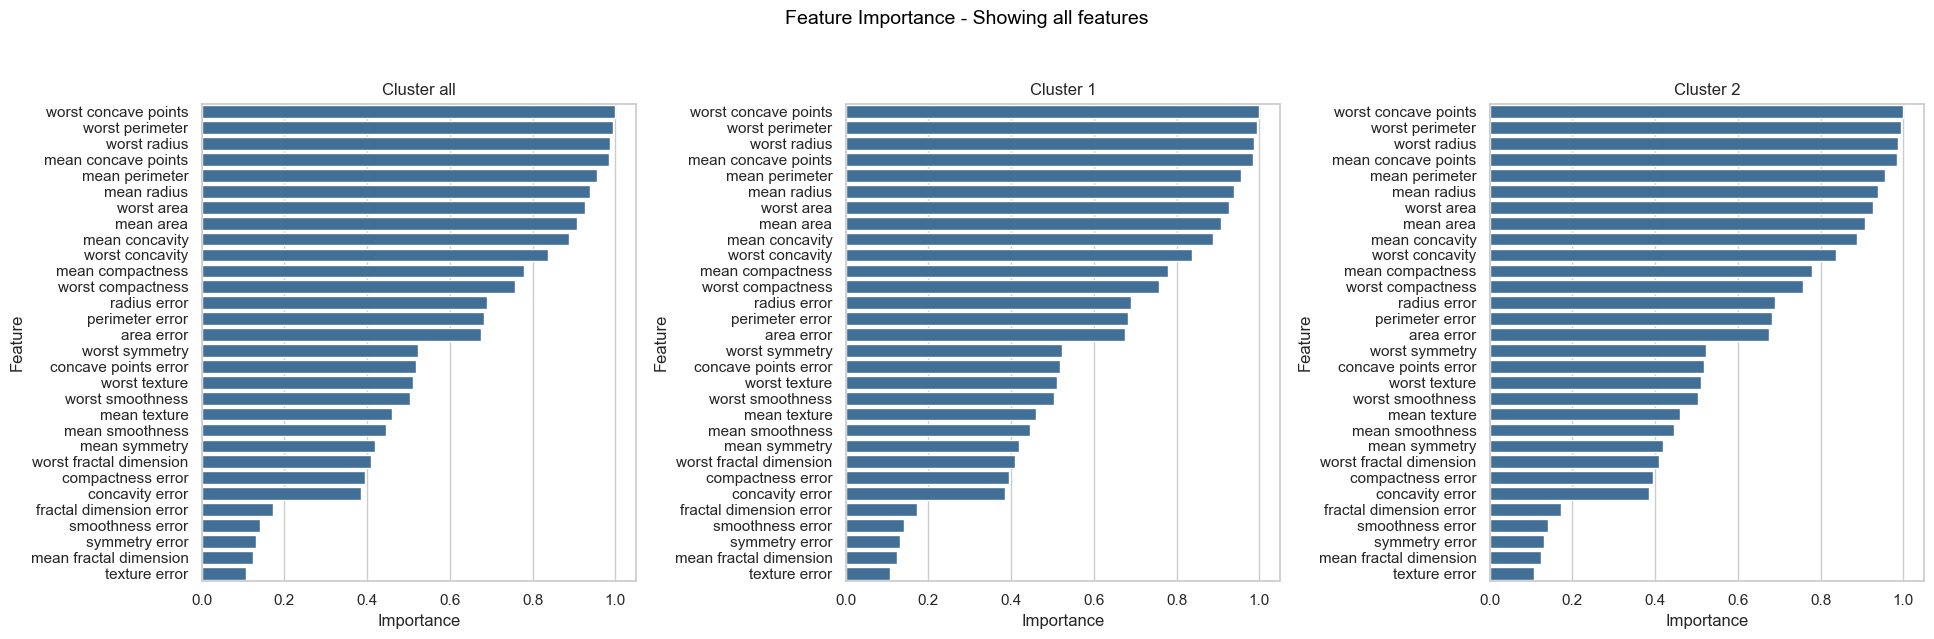

In [6]:
plot_forest_guided_feature_importance(
    feature_importance_local=feature_importance.feature_importance_local,
    feature_importance_global=feature_importance.feature_importance_global
)

The resulting plot helps interpret which features are most responsible for the forest-defined segmentation of the data. In the example above, we can see that approximately half of the features contribute to distinguishing clusters on a global level. Additionally, the local feature importance highlights that some features are consistently important across both clusters, while others are only influential in a single cluster—indicating feature-cluster-specific effects.

Now that we’ve clustered the data using Random Forest decision paths and identified the most important features, we can visually explore how the forest segments the data using the `plot_forest_guided_decision_paths()` function. This visualization provides deeper insights into the decision logic of the Random Forest model by combining heatmaps and feature distribution plots.

The function generates two types of visualizations:

* **Heatmap**: A cluster-level overview showing target value attribution and feature enrichment or depletion. This allows users to inspect which clusters correspond to which classes or target values. Samples that end up in unexpected clusters may indicate outliers, mislabeled data, or measurement noise.
* **Feature Distributions**: These plots show the raw feature distributions across clusters without standardization. They provide insight into the within-cluster variance and actual value ranges, helping assess how features vary between and within clusters.


The function requires the following inputs:

* `data_clustering`: A DataFrame containing the cluster labels, target values, and selected features, retruned by `forest_guided_feature_importance()`.
* `model_type`: a string indicating if the model is a classifier or regressor retruned by the `forest_guided_clustering()`.

Optional parameters include:

* `distributions` (bool): Whether to show feature distribution plots for each cluster (default: True).
* `heatmap` (bool): Whether to show the decision path heatmap (default: True).
* `heatmap_type`: Either "static" (default) or "interactive", depending on the desired plot style.
* `top_n`: The number of top-ranked features to visualize based on global feature importance. If *None*, all features are shown.
* `num_cols`: Number of plots per row in the output layout (default: 6).
* `cmap_target_dict`: Optional color mapping for categorical targets.
* `save`: Path to save the output plots to disk. If *None*, plots are displayed but not saved.

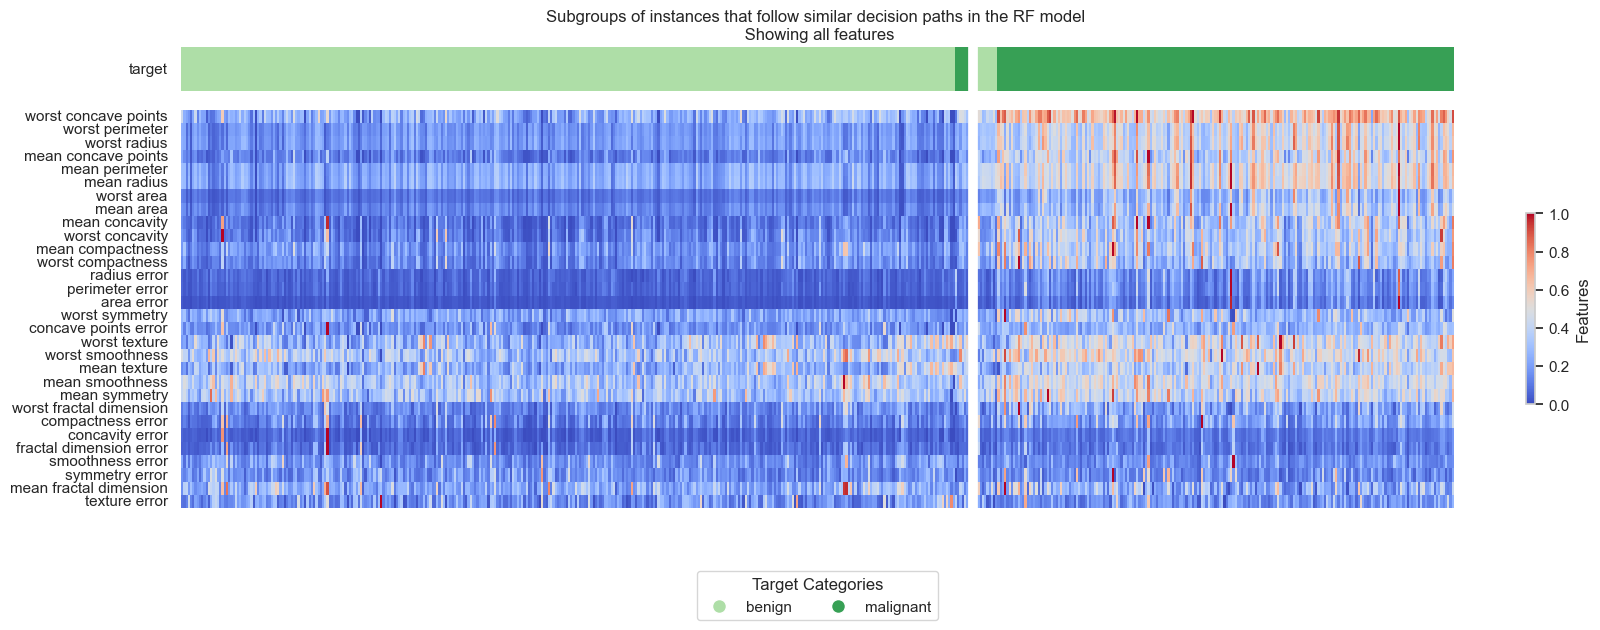

In [7]:
plot_forest_guided_decision_paths(
    data_clustering=feature_importance.data_clustering,
    model_type=fgc.model_type,
    distributions=False,
)

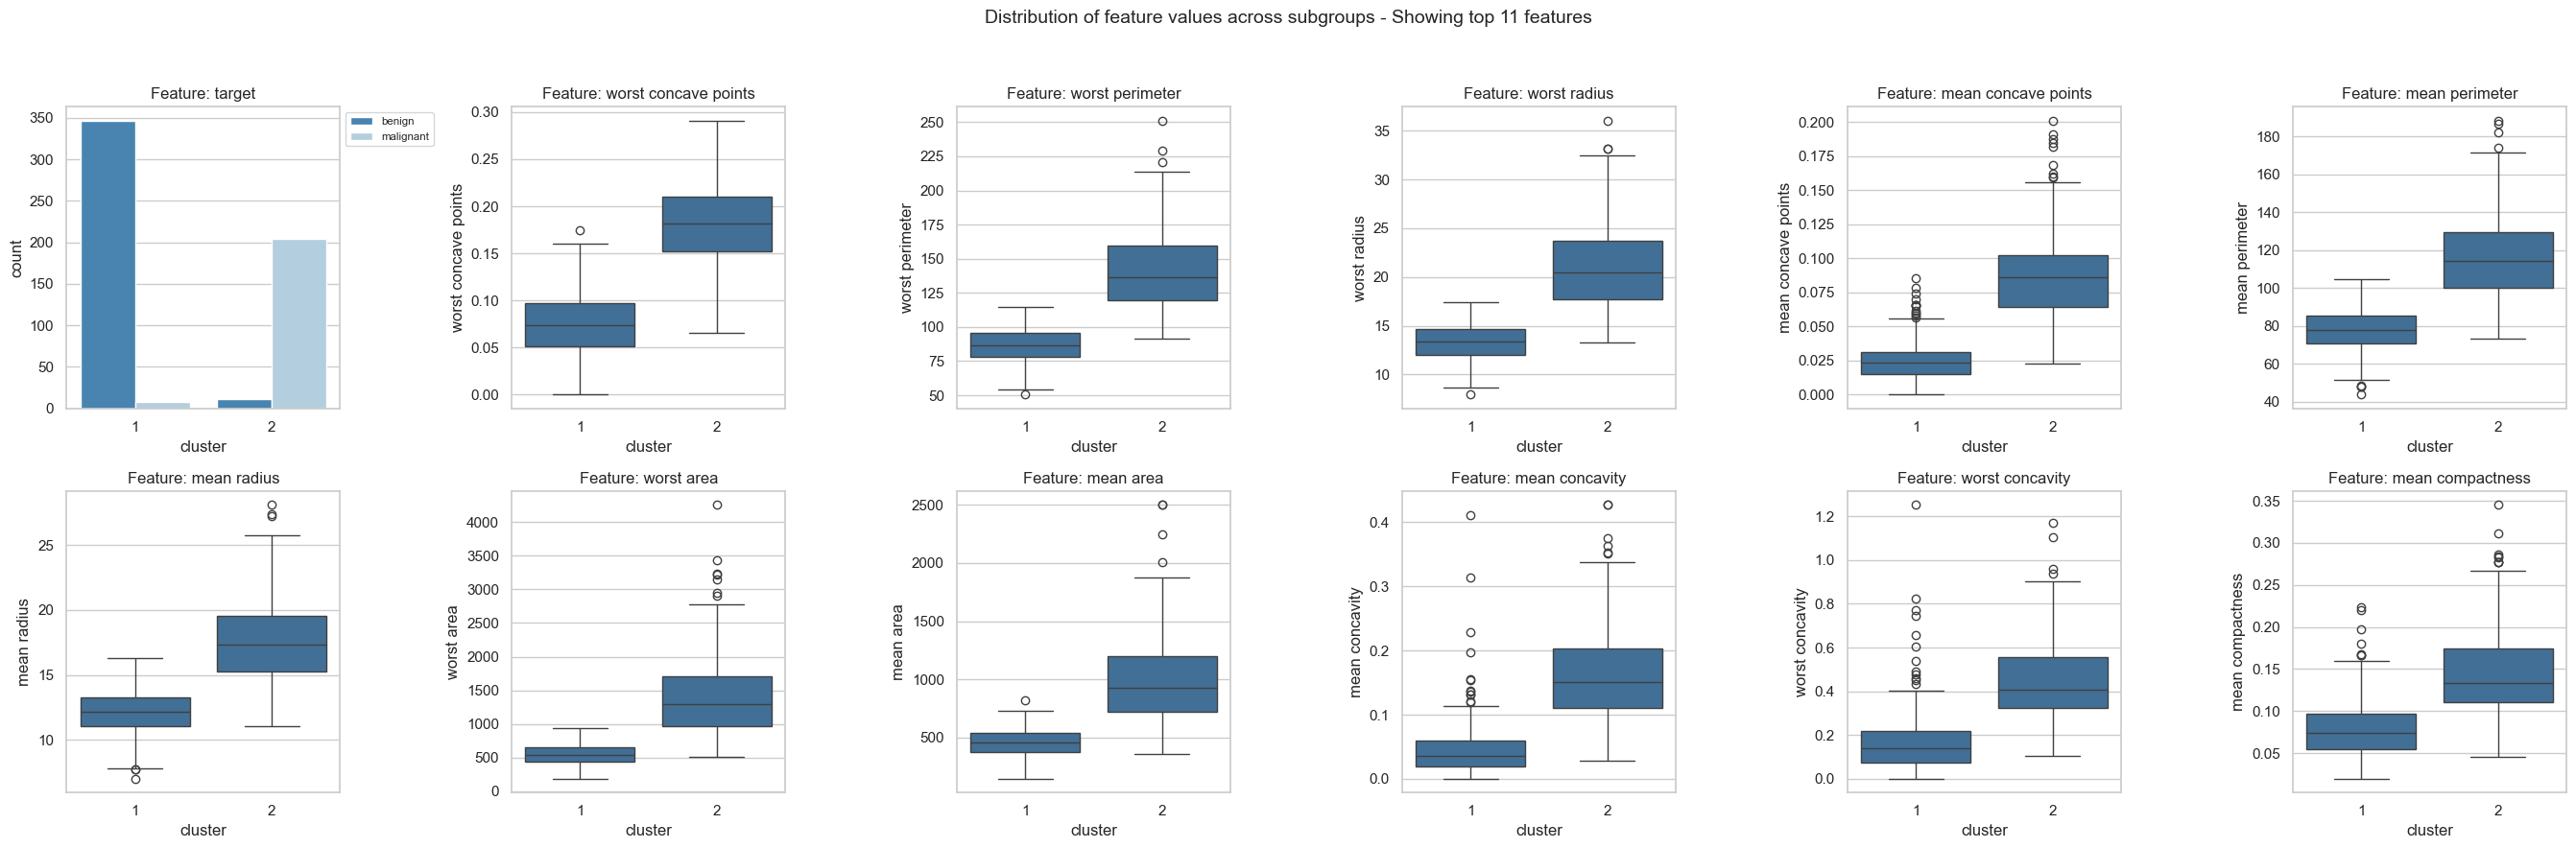

In [8]:
plot_forest_guided_decision_paths(
    data_clustering=feature_importance.data_clustering,
    model_type=fgc.model_type,
    heatmap=False,
    top_n=11,
)

From the resulting plots, we can draw the following conclusions about malignant and benign tumors:

* The two target classes are almost perfectly separated into the two clusters, with only a small number of samples assigned to the “wrong” cluster. These misclassified instances could be further investigated for potential labeling errors or outlier behavior.
* The highest-ranked features in both the feature importance plots and the distribution plots exhibit the most significant differences in values between the clusters.
* Samples in Cluster 0 (corresponding predominantly to benign tumors) consistently show lower values for the most important features compared to samples in Cluster 1 (malignant tumors). Specifically, malignant tumors tend to have more pronounced concave points (worst), greater compactness, and larger radius and perimeter measurements—indicating more irregular and aggressive tumor characteristics.

## Use Case 2: Forest-Guided Clustering for a Random Forest Classifier (Multiclass Classification)

The second use case demonstrates how Forest-Guided Clustering (FGC) can be applied to interpret a multiclass classification model. 

### 🐧  Data Pre-Processing and Model Training

Here, we train a Random Forest classifier on the *Palmer Penguins* dataset from the `palmerpenguins` package. For more information about this dataset, see the [Palmer Penguins GitHub repository](https://github.com/mcnakhaee/palmerpenguins). The dataset includes 344 penguin observations collected from islands in the Palmer Archipelago near Palmer Station, Antarctica. It contains three species of penguins: 146 Adelie, 68 Chinstrap, and 119 Gentoo. Each penguin is described by a combination of numerical and categorical features, including body size measurements, clutch observations, blood isotope ratios, and sex.

In [9]:
data_penguins = load_penguins()

# Remove the instances with missing values and check how many we are left with
print(f"Before omiting the missing values the dataset has {data_penguins.shape[0]} instances")
data_penguins.dropna(inplace=True)
print(f"After omiting the missing values the dataset has {data_penguins.shape[0]} instances")

data_penguins.head()

Before omiting the missing values the dataset has 344 instances
After omiting the missing values the dataset has 333 instances


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


We trained a Random Forest classifier on the entire dataset and optimized the hyperparameters using 5-fold cross-validation. Specifically, we tuned the `max_depth` and `max_features` parameters to improve model performance. To keep the process simple and because Random Forests provide an out-of-bag (OOB) accuracy estimate, we did not perform a separate train/test split. Additionally, to incorporate categorical features into the model, we applied one-hot encoding using dummy variables, making them suitable for use with the Random Forest classifier.

In [10]:
# preprocess categorical features such that they can be used for the RF model
data_penguins_encoded = pd.get_dummies(data_penguins, columns=['island', 'sex'], prefix=['island', 'sex'], drop_first=True)

X_penguins = data_penguins_encoded.loc[:, data_penguins_encoded.columns != 'species']
y_penguins = data_penguins_encoded.species

classifier = RandomForestClassifier(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_classifier = GridSearchCV(classifier, grid, cv=5)
grid_classifier.fit(X_penguins, y_penguins)
rf_penguins = grid_classifier.best_estimator_

print(f'Parameters of best prediction model: {grid_classifier.best_params_}')
print(f'OOB accuracy of prediction model: {round(rf_penguins.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'sqrt'}
OOB accuracy of prediction model: 0.985


### Compute the Forest-Guided Clusters

We now apply the Forest-Guided Clustering (FGC) method to gain insight into which characteristics most strongly influence the classification of the different penguin species. To do this, we use the preprocessed penguins dataset along with the trained Random Forest classifier as input to the `forest_guided_clustering()` function. This function requires the trained estimator, the feature matrix `X`, the corresponding target labels `y`, a distance metric (here we use `DistanceRandomForestProximity()`), and a clustering strategy such as `ClusteringKMedoids()`.

Once initialized, the clustering process is executed and returns the optimal number of clusters along with cluster assignments for each sample. For more details on the function parameters, please refer to the binary classification example above.

In [11]:
fgc = forest_guided_clustering(
    estimator=rf_penguins, 
    X=X_penguins, 
    y=y_penguins, 
    clustering_distance_metric=DistanceRandomForestProximity(), 
    clustering_strategy=ClusteringKMedoids(method="fasterpam", max_iter=200)
)

Using a sample size of 80.0 % of the input data for Jaccard Index computation.
Using range k = (2, 6) to optimize k.


Optimizing k: 100%|██████████| 5/5 [00:28<00:00,  5.75s/it]


Optimal number of clusters k = 3

Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                                                 Cluster_JI
 2 0.296326    True    0.994                                       {1: 0.996, 2: 0.993}
 3 0.018666    True    0.997                             {1: 0.997, 2: 0.997, 3: 0.996}
 4 0.077212    True    0.988                       {1: 0.974, 2: 0.977, 3: 1.0, 4: 1.0}
 5 0.025349    True    0.901           {1: 0.979, 2: 0.777, 3: 0.913, 4: 1.0, 5: 0.836}
 6 0.021124    True    0.965 {1: 0.986, 2: 0.933, 3: 0.974, 4: 1.0, 5: 0.966, 6: 0.929}


### Evaluate Feature Importance 

Based on the output of the `forest_guided_clustering()` function, we observe that the optimal number of clusters is *k = 3*, which yields the lowest clustering score while maintaining high stability, as indicated by a strong Jaccard Index. This aligns well with the true number of penguin species in the dataset and reflects the model’s ability to distinguish meaningful subgroups. When examining the feature importance, we notice that categorical variables such as island have been one-hot encoded, resulting in multiple binary features (e.g., island_Dream, island_Torgersen). Each represents a category, making interpretation more difficult.

100%|██████████| 8/8 [00:00<00:00, 695.83it/s]


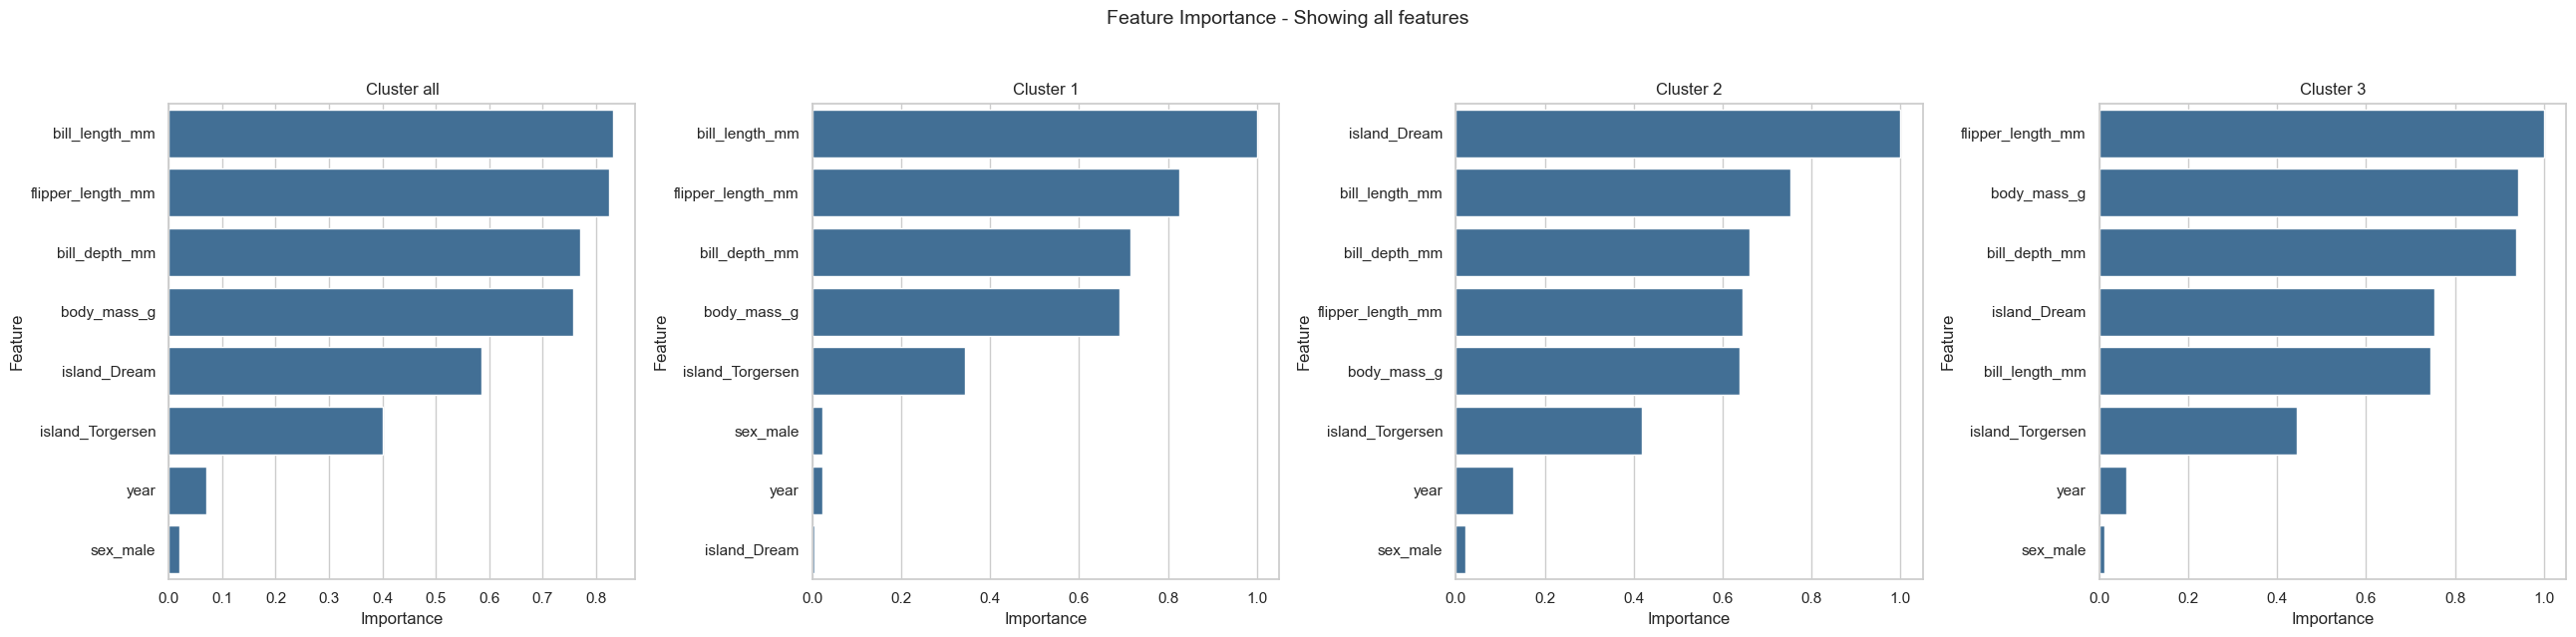

In [12]:
feature_importance = forest_guided_feature_importance(
    X=X_penguins, 
    y=y_penguins, 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
    feature_importance_distance_metric="jensenshannon",
)

plot_forest_guided_feature_importance(
    feature_importance_local=feature_importance.feature_importance_local,
    feature_importance_global=feature_importance.feature_importance_global
)

To improve interpretability, we can provide an alternative feature matrix when computing feature importance. This alternative matrix should contain the original, unencoded categorical variables and must preserve the same number and order of samples as the matrix used during forest guided clustering, as the clustering is based on sample proximities, not feature values. You can pass this alternative matrix to the `forest_guided_feature_importance()` function to ensure the calculated distances and importance scores reflect the original categorical structure. This makes the output plots more intuitive and interpretable for both local and global feature importance, as well as for the decision path visualizations.

100%|██████████| 7/7 [00:00<00:00, 611.47it/s]


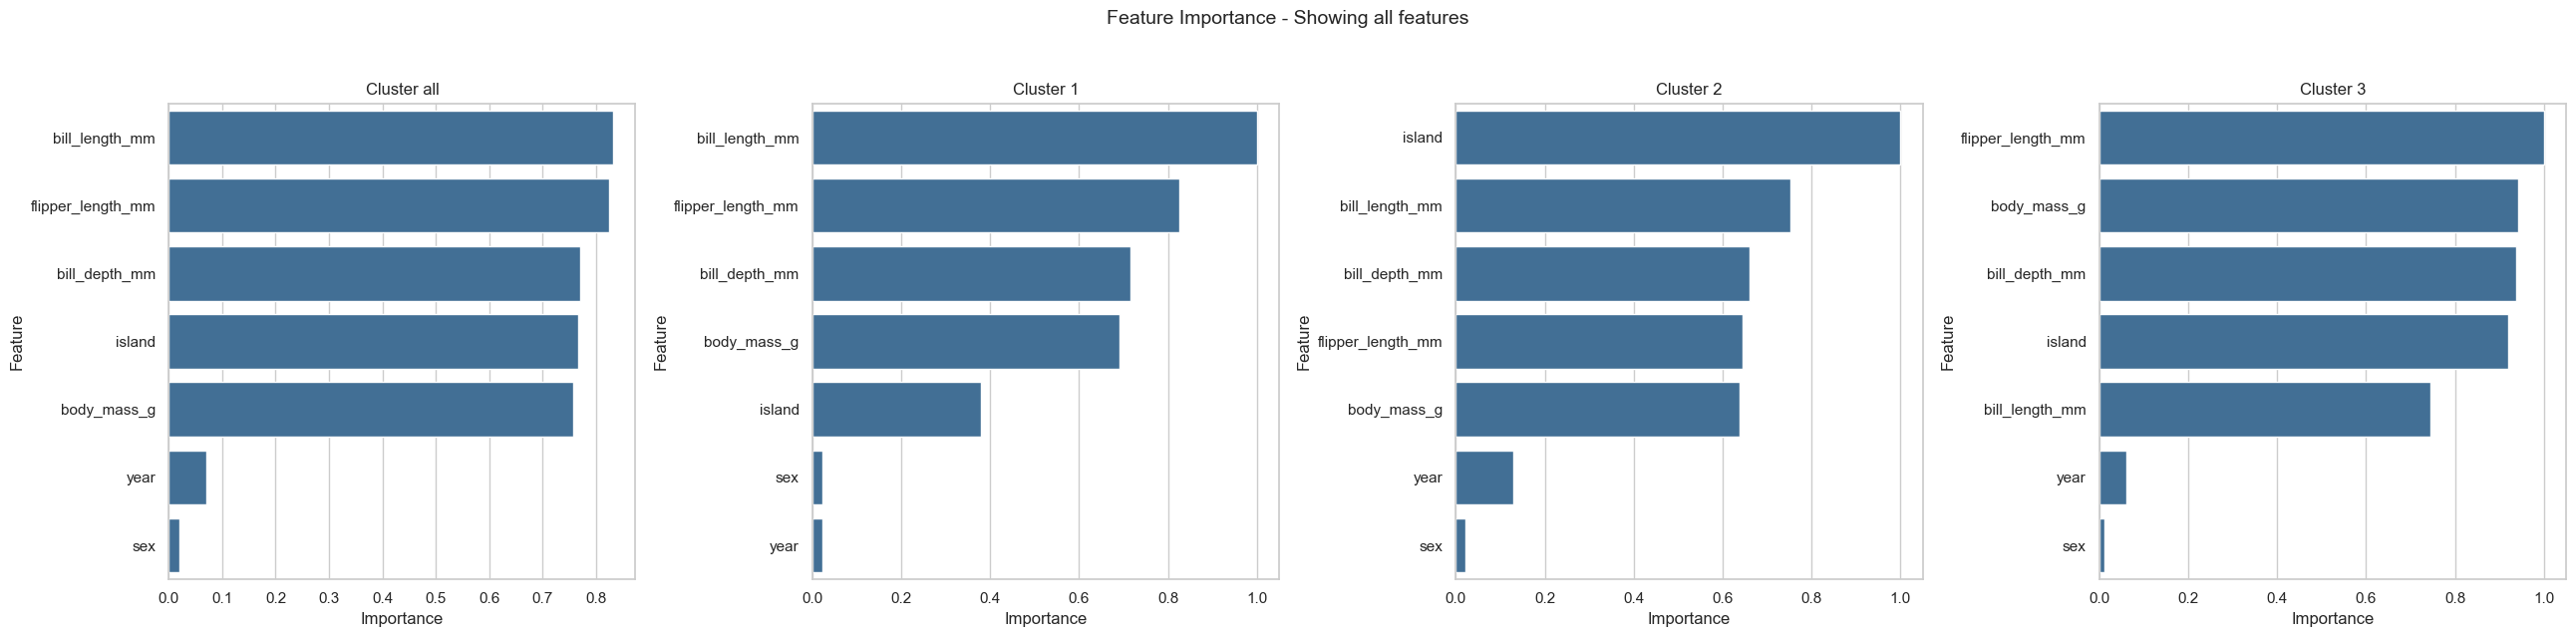

In [13]:
X_add_features = data_penguins.drop('species', axis=1)
X_add_features['island'] = X_add_features['island'].astype('category')
X_add_features['sex'] = X_add_features['sex'].astype('category')

feature_importance = forest_guided_feature_importance(
    X=X_add_features, 
    y=y_penguins, 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
    feature_importance_distance_metric="jensenshannon",
)

plot_forest_guided_feature_importance(
    feature_importance_local=feature_importance.feature_importance_local,
    feature_importance_global=feature_importance.feature_importance_global
)

### Visualize the Results

/Users/lisasousa/Desktop/fgc_projects/fg-clustering/fgclustering/plotting.py:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = data_clustering_ranked.groupby(["cluster", feature]).size().unstack(fill_value=0)
/Users/lisasousa/Desktop/fgc_projects/fg-clustering/fgclustering/plotting.py:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = data_clustering_ranked.groupby(["cluster", feature]).size().unstack(fill_value=0)


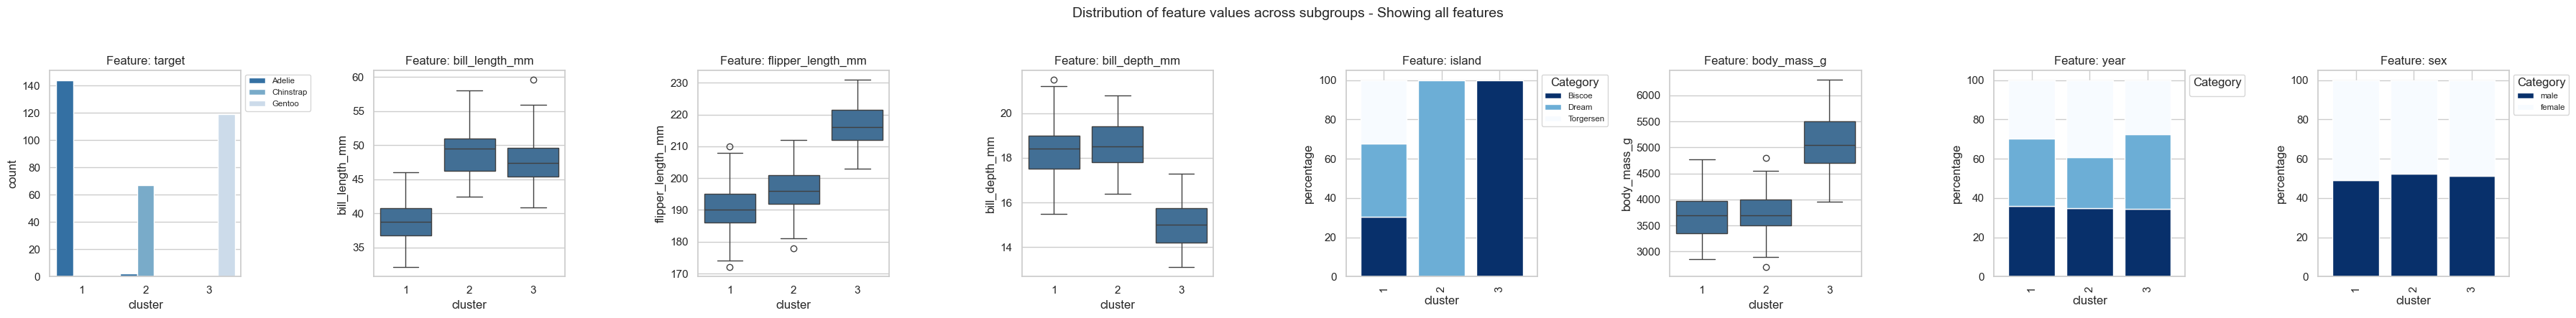

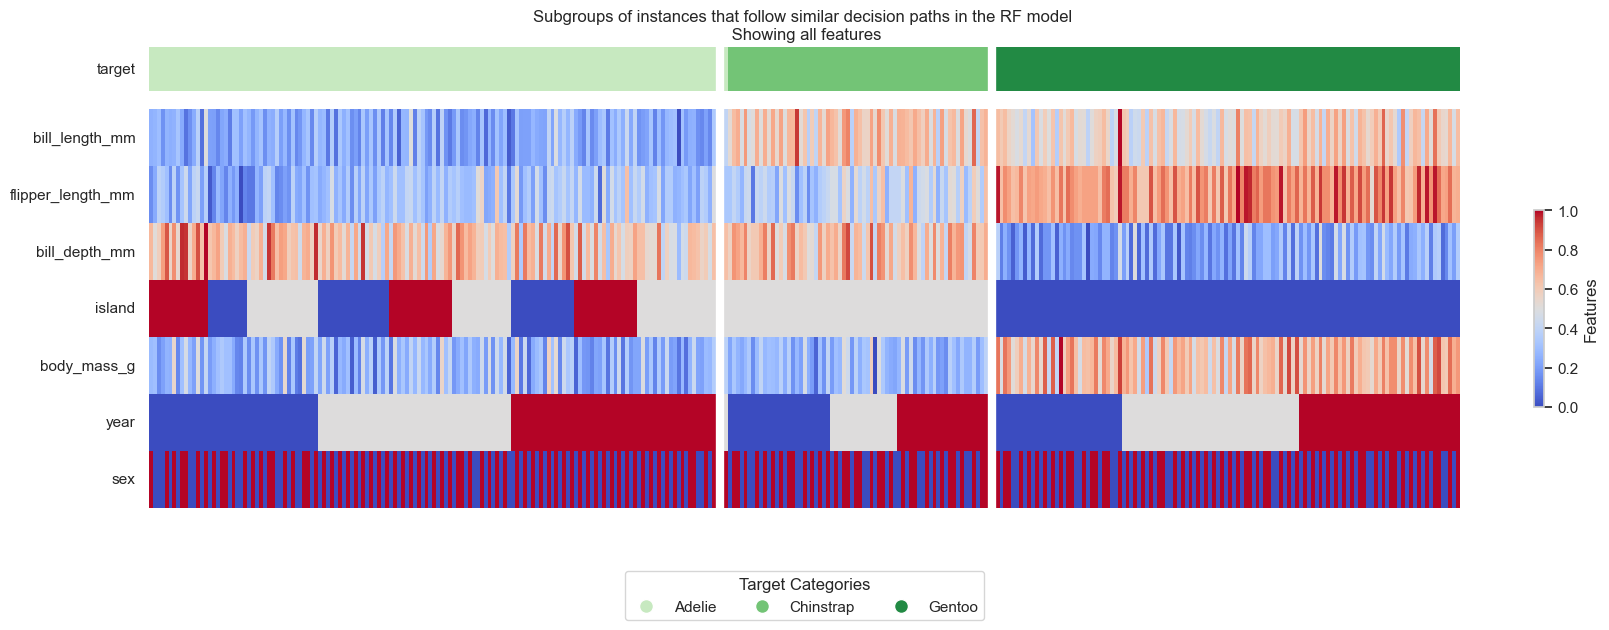

In [14]:
plot_forest_guided_decision_paths(
    data_clustering=feature_importance.data_clustering,
    model_type=fgc.model_type,
    num_cols=8
)

From the resulting plots, we can draw several important conclusions regarding the clustering and its alignment with the true penguin species:

* The three penguin species are almost perfectly separated into the three discovered clusters. Only a small number of *Adelie* penguins are misassigned, which may warrant further inspection, e.g. to check for measurement anomalies or natural variability.
* All features, with the exception of *year* and *sex*, contribute significantly to distinguishing the clusters, as evidenced by their global and local feature importance values and their differentiated distributions across clusters.
* **Cluster 0** contains exclusively *Adelie* penguins. These penguins are distributed across all three islands and are characterized by short flipper and bill lengths, low body mass, and deep bills.
* **Cluster 2** consists solely of *Gentoo* penguins. This species exhibits opposing traits compared to *Adelie* penguins, such as longer flipper and bill lengths, higher body mass, and shallower bills. Gentoo penguins are exclusively observed on Dream Island.
* **Cluster 1** predominantly contains *Chinstrap* penguins. These birds are defined by relatively short flipper length and body mass, but long and deep bills. Interestingly, they are found only on Biscoe Island.

These results illustrate how Forest-Guided Clustering captures biologically meaningful structure in the data, aligning well with known species distinctions and offering a useful interpretation of the Random Forest’s decision patterns.

## Use Case 3: Forest-Guided Clustering for Regression Models

This use case demonstrates how Forest-Guided Clustering (FGC) can be applied to interpret a Random Forest Regressor. 

### 🏘️ Data Pre-Processing and Model Training

We use the California Housing dataset from `sklearn.datasets` ([dataset details here](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset)), which includes 20,640 observations of median house values in California districts (expressed in \$100,000) described by 8 numerical features, such as median income, housing age, and geographic coordinates.

In [15]:
data_housing = fetch_california_housing(as_frame=True).frame

# for sake of runtime we only use the first 1000 samples
data_housing = data_housing.iloc[:1000]
data_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We trained a Random Forest Regressor on the entire dataset and performed hyperparameter tuning via 5-fold cross-validation, optimizing for `max_depth` and `max_features`. Since the model provides out-of-bag (OOB) scores, we skipped creating separate train/test splits for simplicity.

In [16]:
X_housing = data_housing.loc[:, data_housing.columns != 'MedHouseVal']
y_housing = data_housing.MedHouseVal

regressor = RandomForestRegressor(max_samples=0.8, bootstrap=True, oob_score=True, random_state=42)

grid = {'max_depth':[2, 5], 'max_features': ['sqrt', 'log2']}
grid_regressor = GridSearchCV(regressor, grid, cv=5)
grid_regressor.fit(X_housing, y_housing)
rf_housing = grid_regressor.best_estimator_

print(f'Parameters of best prediction model: {grid_regressor.best_params_}')
print(f'OOB R^2 of prediction model: {round(rf_housing.oob_score_,3)}')

Parameters of best prediction model: {'max_depth': 5, 'max_features': 'log2'}
OOB R^2 of prediction model: 0.74


### Forest Guided Clustering Results

To gain insights into how the model organizes the data internally, we apply the Forest-Guided Clustering algorithm. We pass the trained regressor, the preprocessed feature matrix, and the original target variable into the `forest_guided_clustering()` function along with a proximity-based distance metric (`DistanceRandomForestProximity()`) and a clustering strategy (`ClusteringKMedoids()`). In this case, we specify a Jaccard Index threshold of 0.8 to ensure high clustering stability, only retaining patterns that are robust across bootstrap samples. For further parameter details, refer to the earlier binary classification example.

In [17]:
fgc = forest_guided_clustering(
    k=(2,4),
    estimator=rf_housing, 
    X=X_housing, 
    y=y_housing, 
    clustering_distance_metric=DistanceRandomForestProximity(), 
    clustering_strategy=ClusteringKMedoids(),
    JI_discart_value=0.8,
    n_jobs=2,
)

Using a sample size of 80.0 % of the input data for Jaccard Index computation.
Using range k = (2, 4) to optimize k.


Optimizing k: 100%|██████████| 3/3 [00:11<00:00,  3.80s/it]


Optimal number of clusters k = 4

Clustering Evaluation Summary:
 k    Score  Stable  Mean_JI                              Cluster_JI
 2 0.726951    True    0.904                    {1: 0.879, 2: 0.929}
 3      NaN   False    0.773          {1: 0.921, 2: 0.625, 3: 0.774}
 4 0.423497    True    0.936 {1: 0.898, 2: 0.94, 3: 0.961, 4: 0.944}


100%|██████████| 8/8 [00:00<00:00, 1236.85it/s]


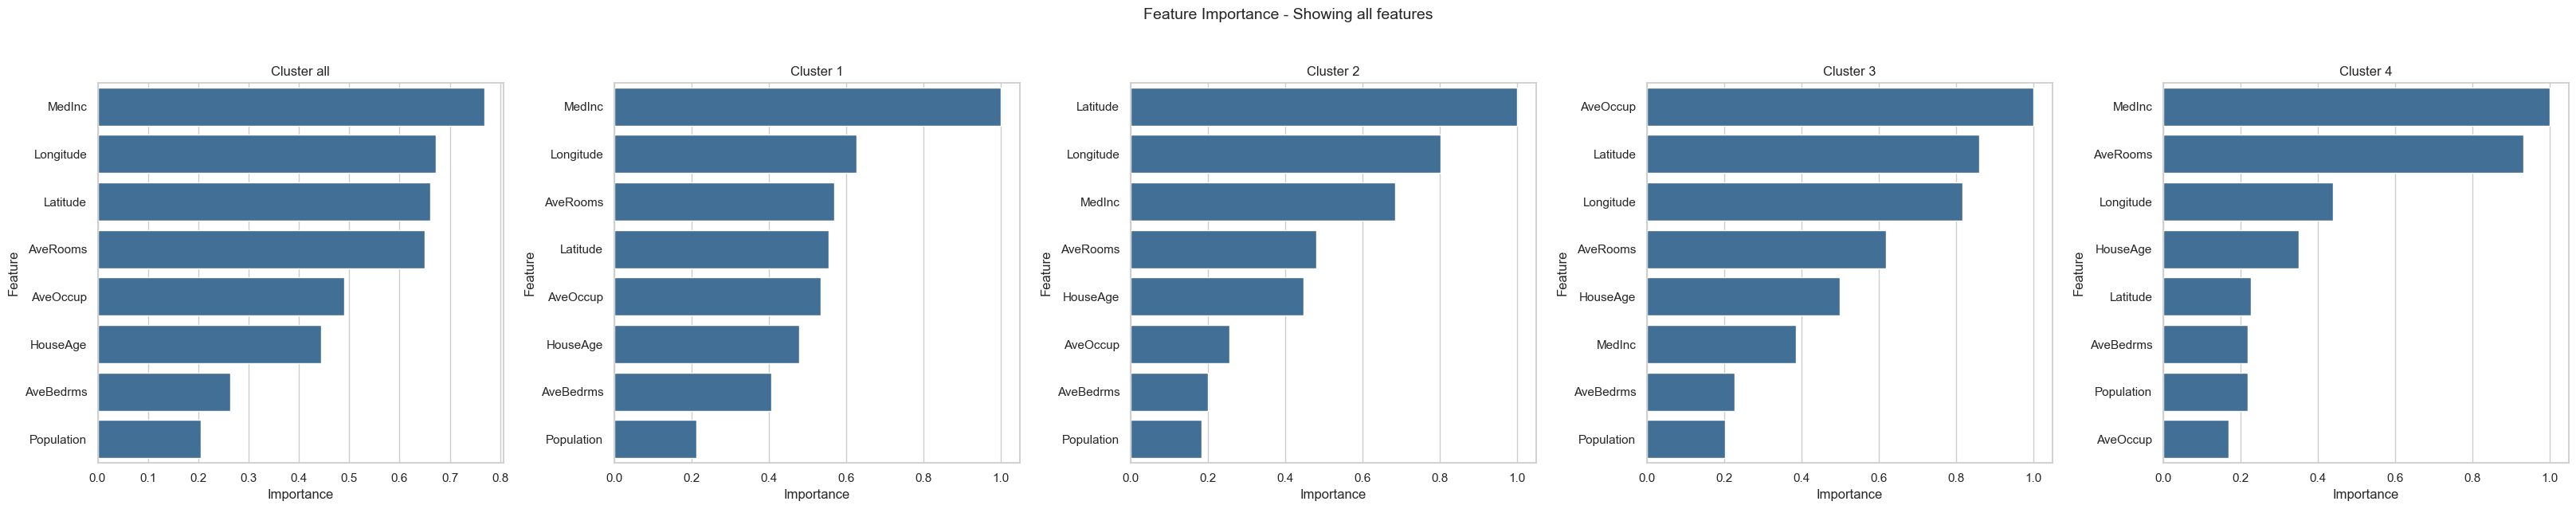

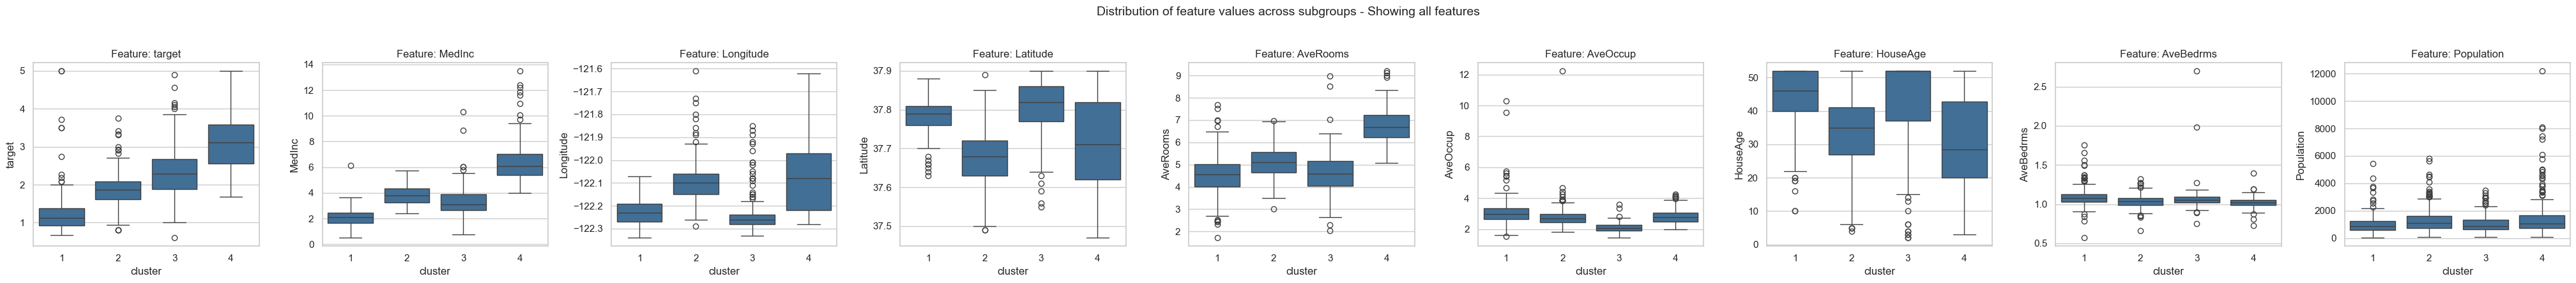

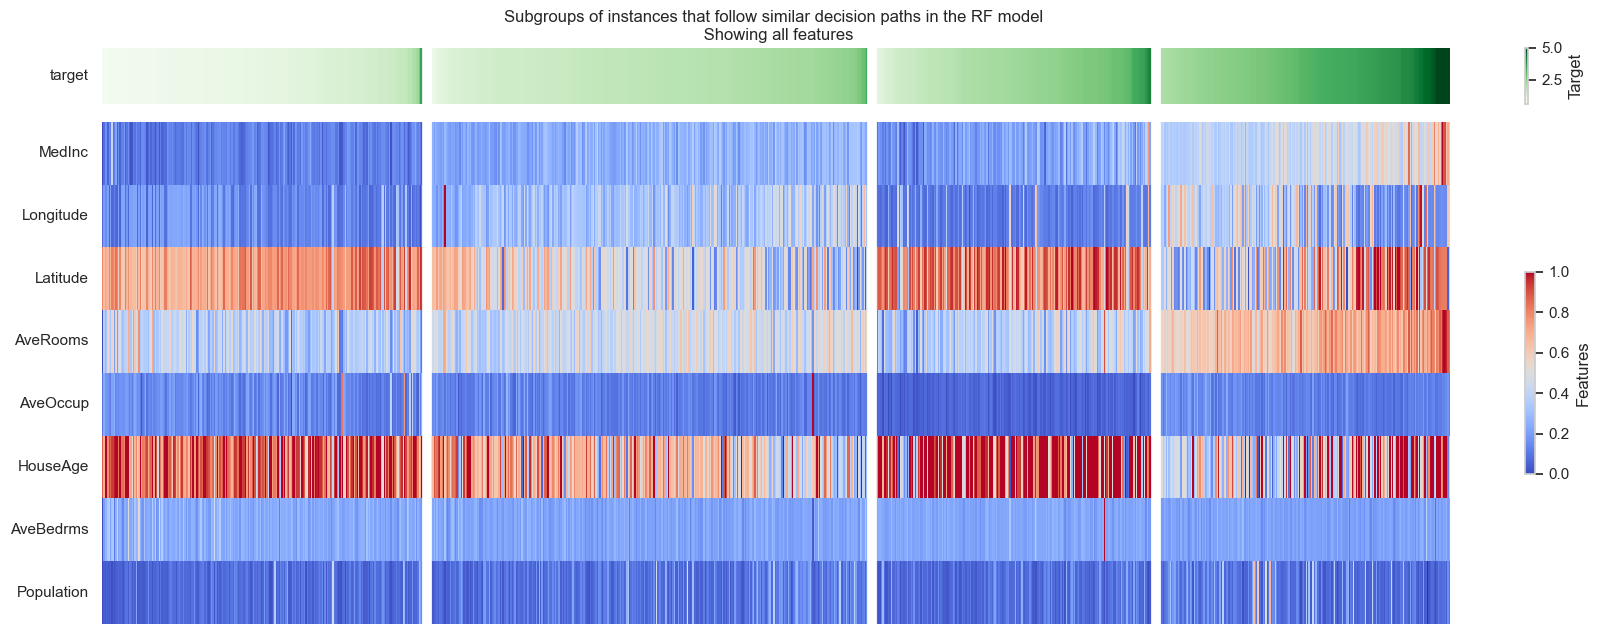

In [18]:
feature_importance = forest_guided_feature_importance(
    X=X_housing, 
    y=y_housing, 
    cluster_labels=fgc.cluster_labels,
    model_type=fgc.model_type,
)
plot_forest_guided_feature_importance(
    feature_importance_local=feature_importance.feature_importance_local,
    feature_importance_global=feature_importance.feature_importance_global,
    num_cols=5,
)
plot_forest_guided_decision_paths(
    data_clustering=feature_importance.data_clustering,
    model_type=fgc.model_type,
    num_cols=9
)

The clustering output reveals four distinct subgroups in the dataset, each reflecting a different profile of housing values and related features:

* **Clusters 1 and 4** represent the extremes. Cluster 0 contains low-valued houses, typically located in the city center, characterized by low median income, high housing age, and high occupancy. In contrast, Cluster 3 includes highly valued properties, situated farther from the city center, toward the mountains. These homes are newer, have many rooms, and are occupied by high-income households.

* **Clusters 2 and 3** capture intermediate housing values. Both clusters are associated with middle-income residents, but differ in other dimensions:

  * **Cluster 3** comprises older homes in the city center, typically with fewer rooms and lower occupancy, possibly single or couple households.
  * **Cluster 2** includes newer homes located outside the center, closer to the airport, with more rooms and higher occupancy, suggestive of family households.

These patterns offer interesting insights beyond what a simple feature importance ranking can provide. Notably, the clusters also highlight the *nonlinear* relationship between geographic location and housing prices: the spatial influence of latitude, longitude, and house age on property values does not follow a straight line, underscoring why a Random Forest (a nonlinear model) outperforms linear alternatives in this setting. Forest-Guided Clustering enables us to uncover meaningful, human-interpretable subgroups within the regression problem. These clusters not only align with known socioeconomic and geographic patterns but also allow us to hypothesize about latent subpopulations, such as low-income urban renters, middle-class suburban families, and high-income rural homeowners, thereby enhancing the transparency and trustworthiness of the Random Forest model’s decision logic.